### 🤖 What are Multi-Agent RAG Systems?
A Multi-Agent RAG System splits the RAG pipeline into multiple specialized agents — each responsible for a specific role — and enables them to collaborate on a single query or task.

#### 1. 📋 Multi-Agent Network RAG System with LangGraph
Project Overview

A Retrieval-Augmented Generation (RAG) system that uses a multi-agent architecture to intelligently answer questions from documents. Built with LangGraph v0.3 for workflow orchestration and OpenAI for language understanding.

What It Does

Transforms your documents (PDFs, text files) into a searchable knowledge base that can answer questions intelligently using AI. Simply upload documents and ask questions in natural language - the system finds relevant information and generates comprehensive answers.
Key Features

- 📚 Multi-Format Support: Handles PDF and text documents
- 🤖 3-Agent Architecture: Specialized agents for document processing, retrieval, and answer generation
- 🔍 Smart Search: Vector-based semantic search finds relevant information
- 💬 Natural Language Q&A: Ask questions in plain English


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain.chat_models import init_chat_model

os.environ["TAVILY_API_KEY"]="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"

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [2]:
llm=init_chat_model("openai:gpt-4o-mini")
llm

ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x109c3e900>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x109c3f380>, root_client=<openai.OpenAI object at 0x109c3c1a0>, root_async_client=<openai.AsyncOpenAI object at 0x109c3f0e0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [7]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [8]:
tavily_tool = TavilySearch(max_results = 5)

In [10]:
# generic function to create a retrieval tool
from langchain_core.tools import Tool

def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    retriever = vs.as_retriever()

    def tool_func(query:str)->str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name,description=desc,func=tool_func)


internal_tool_1 = make_retriever_tool_from_text("internal_docs.txt",
                                              "InternalResearchNotes",
                                              "Search internal research notes for experimental results")

internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x10b3c71a0>)

In [15]:
from langchain_core.messages import BaseMessage, HumanMessage
from langchain.agents import create_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [12]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [16]:
# Reaearch agent and node
from langchain_core.messages import SystemMessage

system_msg = SystemMessage(
    content="You can only do research. Use only bound tools. "
            "You are collaborating with a content writer."
)

llm_with_prompt = llm.bind(messages=[system_msg])

research_agent = create_agent(
    llm_with_prompt,
    tools=[internal_tool_1, tavily_tool]
)


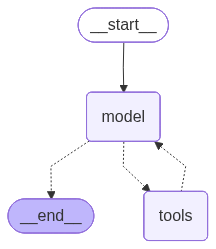

In [17]:
research_agent

In [19]:
## Reaearch node
from typing import Literal

def research_node(state:MessagesState)-> Command[Literal["blog_generator",END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "blog_generator")

    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


In [22]:
# Create blog agent 
blog_agent = create_agent(
    llm,
    tools=[]
)

BLOG_SYSTEM = "You can only write a detailed blog. You are working with a researcher colleague."

def blog_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    # Inject system message at runtime
    state_with_system = {
        **state,
        "messages": [SystemMessage(content=BLOG_SYSTEM)] + state["messages"]
    }

    result = blog_agent.invoke(state_with_system)

    goto = get_next_node(result["messages"][-1], "researcher")

    # Wrap final assistant output as HumanMessage for provider compatibility
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content,
        name="blog_generator"
    )

    return Command(
        update={"messages": result["messages"]},
        goto=goto,
    )


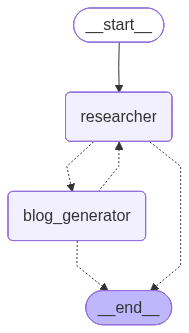

In [23]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("blog_generator", blog_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()
graph

In [25]:
response = graph.invoke({"messages":"Write a detailed blog on transformer variants for production"})

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/GRAPH_RECURSION_LIMIT

In [ ]:
response["messages"][-1].content